In [50]:
# Import Library
%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

Nothing done.


# Prepare and Review Dataset

In [51]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Costruisco le immagini

[   0.  7122.5 6058.7    0.  5764.5 6993.    77.2   72.  5149.8 6780.4]


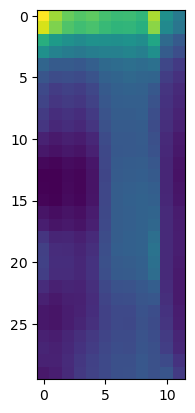

In [52]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"

max = allPixel3.max()
min = allPixel3.min()
training_set = []
test_set = []
choice = np.random.choice(range(allPixel3.shape[0]), size=(790,), replace=False)
ind = np.zeros(allPixel3.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind
training_setX = allPixel3[ind,:,:]
training_setY = newResa3[ind]
training_setX = np.array(training_setX)
training_setY = np.array(training_setY)

test_setX = allPixel3[rest,:,:]
test_setY = newResa3[rest]
test_setX = np.array(test_setX)
test_setY = np.array(test_setY)

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))

#Train Set
for a in range(0,training_setX.shape[0]):
    img = Image.fromarray(training_setX[a,:,:])
    img.save(train_path+str(a)+'.tiff')

#Test Set
for a in range(0,test_setX.shape[0]):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(test_path+str(a)+'.tiff')


In [53]:


# Costruiamo un dataframe Train
dFTrain = pd.DataFrame(columns=['id','target'])
dFTrain['id'] = [str(x)+".tiff" for x in list(range(0,training_setX.shape[0]))]
dFTrain['target'] = training_setY/training_setY.max()
print(dFTrain.head())

# Costruiamo un dataframe Test
dFTest = pd.DataFrame(columns=['id','target'])
dFTest['id'] = [str(x)+".tiff" for x in list(range(0,test_setX.shape[0]))]
dFTest['target'] = test_setY/test_setY.max()

# Prepare the dataset
#Train dataset
train_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTrain, target_size = (32,32),
                                                      directory=train_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

#Test Dataset
test_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTest, target_size = (32,32),
                                                      directory=test_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

       id    target
0  0.tiff  0.146750
1  1.tiff  0.206331
2  2.tiff  0.003492
3  3.tiff  0.215829
4  4.tiff  0.205777
Found 790 validated image filenames.
Found 789 validated image filenames.


# Creazione del modello di Vgg16

In [54]:
# Import model
vgg16 = VGG16(input_shape=(32,32,3),include_top=False)

# Import model
#vgg16 = VGG16()

In [55]:
# layers of vgg16
vgg16_layer_list = vgg16.layers
for i in vgg16_layer_list:
    print(i)

In [56]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16_layer_list)-1):
    vgg16Model.add(vgg16_layer_list[i])

In [57]:
# Close the layers of vgg16
for layers in vgg16Model.layers:
    layers.trainable = False

In [58]:
# Last layer
#vgg16Model.add(Dense(units=1))

vgg16Model.add(Dense(units=1))

In [59]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [60]:
# I create compile part.
vgg16Model.compile(loss = "mean_squared_error",
             optimizer = "rmsprop",
             metrics = ["mse","mae"])

# Training Model 

In [61]:
# Traning with model
batch_size = 32

hist_vgg16 = vgg16Model.fit(train_data, 
                                epochs = 10,
                                validation_data=test_data
                                )

Epoch 1/10
25/25 [==============================] - 8s 296ms/step - loss: 0.2821 - mse: 0.2821 - mae: 0.4205 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1017
Epoch 2/10
25/25 [==============================] - 4s 169ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0866 - val_loss: 0.0138 - val_mse: 0.0138 - val_mae: 0.0713
Epoch 3/10
25/25 [==============================] - 4s 165ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0674 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0854
Epoch 4/10
25/25 [==============================] - 4s 168ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0674 - val_loss: 0.0133 - val_mse: 0.0133 - val_mae: 0.0709
Epoch 5/10
25/25 [==============================] - 4s 179ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0677 - val_loss: 0.0129 - val_mse: 0.0129 - val_mae: 0.0675
Epoch 6/10
25/25 [==============================] - 4s 179ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0669 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0942
Epoch 7/10
25/25

In [62]:
# Save the weights of model
vgg16Model.save_weights("previsioneResa.h5")

# Andiamo a visualizzare i risultati della rete

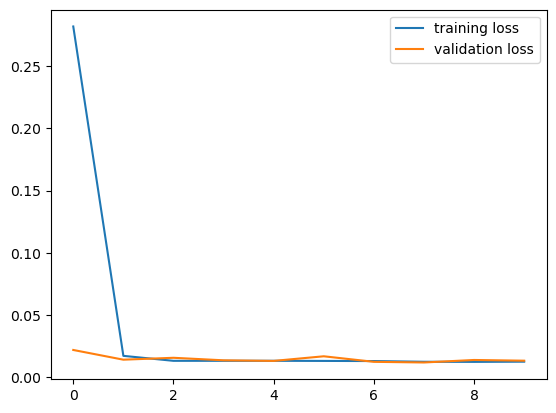

In [89]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

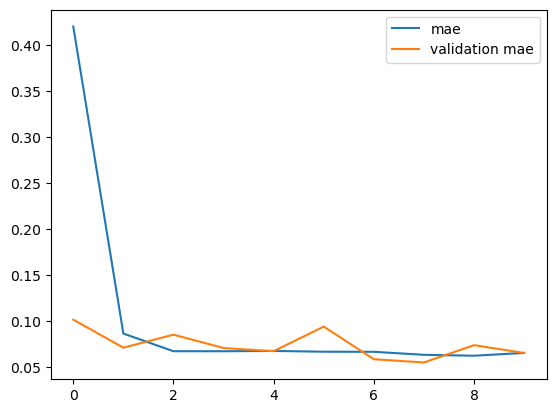

In [88]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["mae"], label = "mae")
plt.plot(hist_vgg16.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

# Salviamo e carichiamo i risultati

In [65]:
import json, codecs
with open("deneme.json","w") as f:
    json.dump(hist_vgg16.history, f)

In [66]:
with codecs.open("./deneme.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())

In [67]:
load_result

{'loss': [0.2821495831012726,
  0.016923412680625916,
  0.012917106971144676,
  0.012927400879561901,
  0.012942078523337841,
  0.01283856388181448,
  0.012735873460769653,
  0.012161538936197758,
  0.012071258388459682,
  0.012236294336616993],
 'mse': [0.2821495831012726,
  0.016923412680625916,
  0.012917106971144676,
  0.012927400879561901,
  0.012942078523337841,
  0.01283856388181448,
  0.012735873460769653,
  0.012161538936197758,
  0.012071258388459682,
  0.012236294336616993],
 'mae': [0.4205152690410614,
  0.08664993941783905,
  0.06743288785219193,
  0.06739845871925354,
  0.06774955242872238,
  0.06689082831144333,
  0.06680422276258469,
  0.0635155439376831,
  0.06253243237733841,
  0.06560647487640381],
 'val_loss': [0.02165919356048107,
  0.013840144500136375,
  0.015365484170615673,
  0.01333385705947876,
  0.012854741886258125,
  0.01657407358288765,
  0.012111104093492031,
  0.011589260771870613,
  0.013601257465779781,
  0.01302512176334858],
 'val_mse': [0.021659193

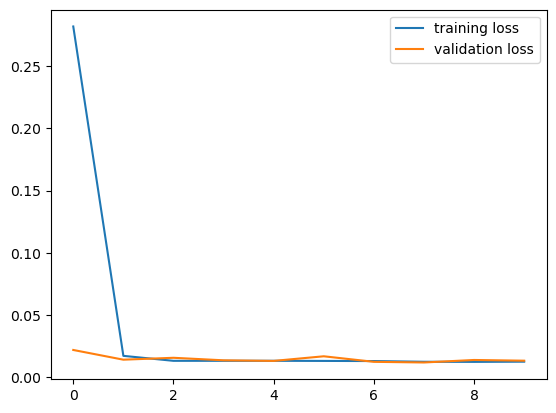

In [87]:
# Loss And Validation Loss
plt.plot(load_result["loss"], label = "training loss")
plt.plot(load_result["val_loss"], label = "validation loss")
plt.legend()
plt.show()

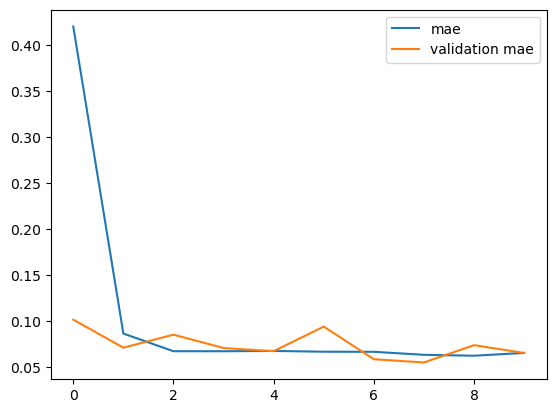

In [86]:
plt.plot(load_result["mae"], label = "mae")
plt.plot(load_result["val_mae"], label = "validation mae")
plt.legend()
plt.show()

# Vgg19

In [70]:
# Import VGG19 model
vgg19 = VGG19(input_shape=(32,32,3),include_top=False)

In [71]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [72]:
# Layers of vgg19 
vgg19_layer_list = vgg19.layers
for i in vgg19_layer_list:
    print(i)

In [73]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
for i in range(len(vgg19_layer_list)-1):
    vgg19Model.add(vgg19_layer_list[i])

In [74]:
# Finish version of my created model.
vgg19Model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [75]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [76]:
# Last layer
vgg19Model.add(Dense(1))

In [77]:
# the final version of the model
vgg19Model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [78]:
# I create compile part.
vgg19Model.compile(loss = "mean_squared_error",
             optimizer = "rmsprop",
             metrics = ["accuracy","mse","mae"])

# Addestramento

In [79]:
# Traning with model
batch_size = 32

# Training with my created model
hisy_vgg19 = vgg19Model.fit_generator(train_data,
                               epochs = 10,
                               validation_data = test_data
                               )

Epoch 1/10
25/25 [==============================] - 6s 203ms/step - loss: 0.0342 - accuracy: 0.0139 - mse: 0.0342 - mae: 0.1217 - val_loss: 0.0148 - val_accuracy: 0.0089 - val_mse: 0.0148 - val_mae: 0.0775
Epoch 2/10
25/25 [==============================] - 5s 200ms/step - loss: 0.0137 - accuracy: 0.0139 - mse: 0.0137 - mae: 0.0747 - val_loss: 0.0146 - val_accuracy: 0.0089 - val_mse: 0.0146 - val_mae: 0.0780
Epoch 3/10
25/25 [==============================] - 5s 198ms/step - loss: 0.0133 - accuracy: 0.0139 - mse: 0.0133 - mae: 0.0722 - val_loss: 0.0126 - val_accuracy: 0.0089 - val_mse: 0.0126 - val_mae: 0.0624
Epoch 4/10
25/25 [==============================] - 5s 206ms/step - loss: 0.0132 - accuracy: 0.0139 - mse: 0.0132 - mae: 0.0708 - val_loss: 0.0121 - val_accuracy: 0.0089 - val_mse: 0.0121 - val_mae: 0.0587
Epoch 5/10
25/25 [==============================] - 5s 208ms/step - loss: 0.0128 - accuracy: 0.0139 - mse: 0.0128 - mae: 0.0673 - val_loss: 0.0121 - val_accuracy: 0.0089 - val_

# Visualizziamo i risultati ottenuti

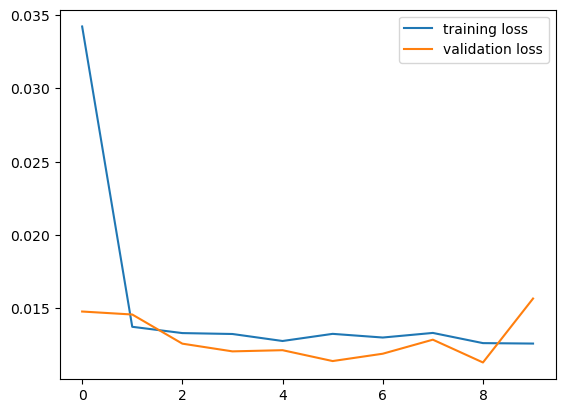

In [85]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

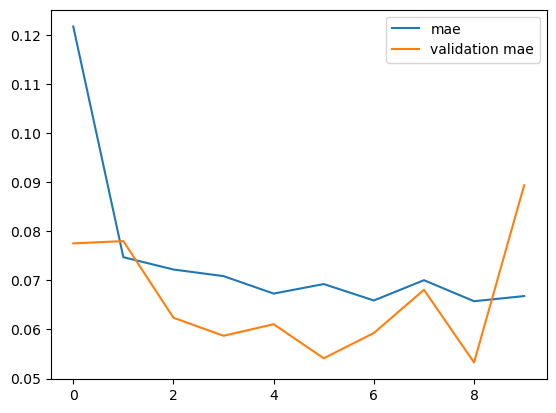

In [84]:
# Accuracy And Validation Accuracy
plt.plot(hisy_vgg19.history["mae"], label = "mae")
plt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()